# Hybrid‑Stack Flood Prediction Pipeline

This notebook implements the hybrid‑stack approach:
1. Load & inspect cleaned data  
2. Leakage diagnostics  
3. Feature engineering (static + cyclical + fuzzy risk)  
4. Encoding & scaling  
5. Time‑aware & spatial CV  
6. Baseline threshold sweep (LogisticRegression)  
7. SMOTE + calibrated tree‑ensemble (with fuzzy risk)  
8. Threshold tuning  
9. Test‑year evaluation  
10. SHAP analysis  
11. Forecast wrapper  
12. Export calibrated pipeline  


In [1]:
# Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.preprocessing    import OneHotEncoder, PowerTransformer
from sklearn.compose          import ColumnTransformer
from sklearn.pipeline         import Pipeline
from sklearn.linear_model     import LogisticRegression
from sklearn.model_selection  import TimeSeriesSplit, LeaveOneGroupOut, cross_val_score
from sklearn.calibration      import CalibratedClassifierCV
from sklearn.metrics          import roc_auc_score, precision_recall_curve, f1_score, confusion_matrix
import joblib

# Imbalanced pipeline & SMOTE
from imblearn.pipeline        import Pipeline as ImbPipeline
from imblearn.over_sampling   import SMOTE

# Tree models
from sklearn.ensemble         import RandomForestClassifier
from xgboost                  import XGBClassifier
from lightgbm                 import LGBMClassifier

# Fuzzy logic
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# SHAP
import shap


In [2]:
# 1. Load & inspect
data_path = Path('../data/cleaned/all_regions.csv')
df = pd.read_csv(data_path, parse_dates=['Date'])

print(df.info())
print("\nClass balance:\n", df['Flood_Status'].value_counts())
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96448 entries, 0 to 96447
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Date                   96448 non-null  datetime64[ns]
 1   Region                 96448 non-null  object        
 2   Precipitation          96448 non-null  float64       
 3   River_Level            96448 non-null  float64       
 4   Elevation_m            96448 non-null  int64         
 5   Slope_deg              96448 non-null  float64       
 6   Drainage_Density       96448 non-null  float64       
 7   Dist_to_River_km       96448 non-null  float64       
 8   Soil_Type              96448 non-null  object        
 9   Land_Cover             96448 non-null  object        
 10  TWI                    96448 non-null  float64       
 11  NDVI                   96448 non-null  float64       
 12  Precipitation_norm     96448 non-null  float64       
 13  R

,Date,Region,Precipitation,River_Level,Elevation_m,Slope_deg,Drainage_Density,Dist_to_River_km,Soil_Type,Land_Cover,...,TWI_norm,NDVI_norm,risk_score,Flood_Status,Lake_Level,Dam_Level,Elevation_m_norm,Drainage_Density_norm,Lake_Level_norm,Dam_Level_norm
0,2015-01-01,Ak-Suu,0.000000,1.674161,1600,8.0,1.4,0.7,sandy_loam,mountain_forest,...,0.616667,1.0,0.080418,0,5.519516,10.752298,0.4,0.214286,0.45648,0.620968
1,2015-01-02,Ak-Suu,6.378744,2.825170,1600,8.0,1.4,0.7,sandy_loam,mountain_forest,...,0.616667,1.0,0.210389,0,5.519516,10.752298,0.4,0.214286,0.45648,0.620968
2,2015-01-03,Ak-Suu,0.661352,3.003257,1600,8.0,1.4,0.7,sandy_loam,mountain_forest,...,0.616667,1.0,0.125043,0,5.519516,10.752298,0.4,0.214286,0.45648,0.620968
3,2015-01-04,Ak-Suu,3.865727,3.360715,1600,8.0,1.4,0.7,sandy_loam,mountain_forest,...,0.616667,1.0,0.184650,0,5.519516,10.752298,0.4,0.214286,0.45648,0.620968
4,2015-01-05,Ak-Suu,3.244595,3.141330,1600,8.0,1.4,0.7,sandy_loam,mountain_forest,...,0.616667,1.0,0.169231,0,5.519516,10.752298,0.4,0.214286,0.45648,0.620968


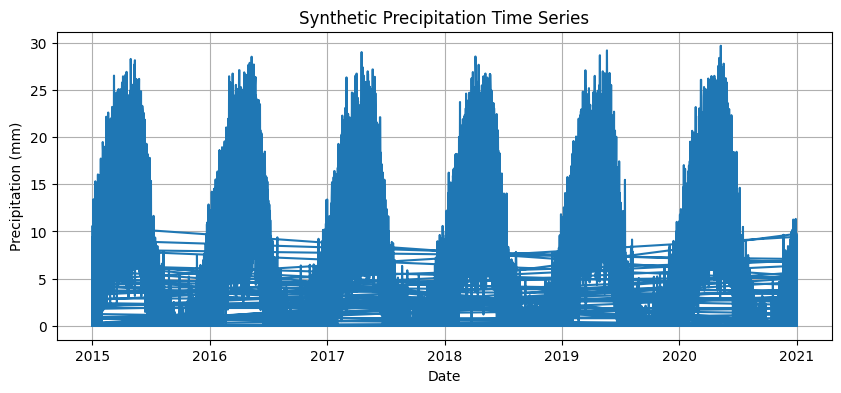

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(df['Date'], df['Precipitation'])
plt.title('Synthetic Precipitation Time Series')
plt.xlabel('Date')
plt.ylabel('Precipitation (mm)')
plt.grid()
plt.show()

In [4]:
# 2. Leakage diagnostics
features = [c for c in df.columns if '_norm' in c] + ['risk_score']
corrs = df[features + ['Flood_Status']].corr()['Flood_Status'].drop('Flood_Status')
print("Correlations with Flood_Status:\n", corrs.sort_values(ascending=False))

# for feat in features:
#     plt.figure(figsize=(5,2))
#     plt.scatter(df[feat], df['Flood_Status'], alpha=0.3)
#     plt.title(f"{feat} vs Flood_Status")
#     plt.show()

# Drop leakage proxies
df = df.drop(columns=features + ['risk_score'])
print("Dropped raw+normalized proxies.")


Correlations with Flood_Status:
 Precipitation_norm       0.559328
risk_score               0.552387
River_Level_norm         0.494380
Lake_Level_norm          0.077156
Dam_Level_norm           0.028371
NDVI_norm                0.007862
Dist_to_River_km_norm    0.005580
TWI_norm                 0.002145
Elevation_m_norm         0.000223
Slope_deg_norm           0.000047
Drainage_Density_norm   -0.005721
Name: Flood_Status, dtype: float64
Dropped raw+normalized proxies.


In [5]:
# 3. Feature engineering: static, cyclical month, fuzzy risk
# a) Static + date features
static_cols = [
    'Elevation_m','Slope_deg','Drainage_Density','Dist_to_River_km',
    'Soil_Type','Land_Cover','TWI','NDVI'
]
df_fe = df[static_cols + ['Date','Region','Flood_Status']].copy()
df_fe['month']     = df_fe['Date'].dt.month
df_fe['month_sin'] = np.sin(2*np.pi*df_fe['month']/12)
df_fe['month_cos'] = np.cos(2*np.pi*df_fe['month']/12)
df_fe.drop('month',axis=1,inplace=True)

# b) Build fuzzy system and compute Fuzzy_Risk
precip = ctrl.Antecedent(np.linspace(0,1,100),'precip')
runoff= ctrl.Antecedent(np.linspace(0,1,100),'runoff')
risk   = ctrl.Consequent(np.linspace(0,1,100),'risk')

precip['low'],  precip['high']  = fuzz.trimf(precip.universe,[0,0,0.5]),  fuzz.trimf(precip.universe,[0.5,1,1])
runoff['low'], runoff['high'] = fuzz.trimf(runoff.universe,[0,0,0.5]), fuzz.trimf(runoff.universe,[0.5,1,1])
risk['low'],    risk['high']    = fuzz.trimf(risk.universe,[0,0,0.5]),    fuzz.trimf(risk.universe,[0.5,1,1])

rule1 = ctrl.Rule(precip['high'] & runoff['high'], risk['high'])
rule2 = ctrl.Rule(precip['low']  | runoff['low'],  risk['low'])
fsys  = ctrl.ControlSystem([rule1, rule2])
sim   = ctrl.ControlSystemSimulation(fsys)

# Extract normalized columns from original df
norm_df = pd.read_csv(Path('../data/cleaned/all_regions.csv'), parse_dates=['Date'])
pn = norm_df['Precipitation_norm'].values
rn = norm_df['River_Level_norm'].values

fuzzy_scores = []
for p_val, r_val in zip(pn, rn):
    sim.input['precip']  = p_val
    sim.input['runoff']  = r_val
    sim.compute()
    fuzzy_scores.append(sim.output['risk'])

df_fe['Fuzzy_Risk'] = fuzzy_scores
df_fe.head()


,Elevation_m,Slope_deg,Drainage_Density,Dist_to_River_km,Soil_Type,Land_Cover,TWI,NDVI,Date,Region,Flood_Status,month_sin,month_cos,Fuzzy_Risk
0,1600,8.0,1.4,0.7,sandy_loam,mountain_forest,15.2,0.6,2015-01-01,Ak-Suu,0,0.5,0.866025,0.166701
1,1600,8.0,1.4,0.7,sandy_loam,mountain_forest,15.2,0.6,2015-01-02,Ak-Suu,0,0.5,0.866025,0.176969
2,1600,8.0,1.4,0.7,sandy_loam,mountain_forest,15.2,0.6,2015-01-03,Ak-Suu,0,0.5,0.866025,0.167017
3,1600,8.0,1.4,0.7,sandy_loam,mountain_forest,15.2,0.6,2015-01-04,Ak-Suu,0,0.5,0.866025,0.175662
4,1600,8.0,1.4,0.7,sandy_loam,mountain_forest,15.2,0.6,2015-01-05,Ak-Suu,0,0.5,0.866025,0.173230


In [6]:
# # 3. Feature engineering: static, cyclical month, fuzzy risk
# # a) Static + date features
# static_cols = [
#     'Elevation_m','Slope_deg','Drainage_Density','Dist_to_River_km',
#     'Soil_Type','Land_Cover','TWI','NDVI'
# ]
# df_fe = df[static_cols + ['Date','Region','Flood_Status']].copy()
# df_fe['month']     = df_fe['Date'].dt.month
# df_fe['month_sin'] = np.sin(2*np.pi*df_fe['month']/12)
# df_fe['month_cos'] = np.cos(2*np.pi*df_fe['month']/12)
# df_fe.drop('month',axis=1,inplace=True)

# # b) Build fuzzy system and compute Fuzzy_Risk
# precip = ctrl.Antecedent(np.linspace(0,1,100),'precip')
# runoff= ctrl.Antecedent(np.linspace(0,1,100),'runoff')
# risk   = ctrl.Consequent(np.linspace(0,1,100),'risk')

# precip['low'],  precip['high']  = fuzz.trimf(precip.universe,[0,0,0.5]),  fuzz.trimf(precip.universe,[0.5,1,1])
# runoff['low'], runoff['high'] = fuzz.trimf(runoff.universe,[0,0,0.5]), fuzz.trimf(runoff.universe,[0.5,1,1])
# risk['low'],    risk['high']    = fuzz.trimf(risk.universe,[0,0,0.5]),    fuzz.trimf(risk.universe,[0.5,1,1])

# rule1 = ctrl.Rule(precip['high'] & runoff['high'], risk['high'])
# rule2 = ctrl.Rule(precip['low']  | runoff['low'],  risk['low'])
# fsys  = ctrl.ControlSystem([rule1, rule2])
# sim   = ctrl.ControlSystemSimulation(fsys)

# # Extract normalized columns from original df
# norm_df = pd.read_csv(Path('../data/cleaned/all_regions.csv'), parse_dates=['Date'])
# pn = norm_df['Precipitation_norm'].values
# rn = norm_df['River_Level_norm'].values

# fuzzy_scores = []
# for p_val, r_val in zip(pn, rn):
#     sim.input['precip']  = p_val
#     sim.input['runoff']  = r_val
#     sim.compute()
#     fuzzy_scores.append(sim.output['risk'])

# df_fe['Fuzzy_Risk'] = fuzzy_scores
# df_fe.head()


In [7]:
# 4. Encode & scale (include Fuzzy_Risk)
cat_feats = ['Soil_Type','Land_Cover']
num_feats = [
    'Elevation_m','Slope_deg','Drainage_Density','Dist_to_River_km',
    'TWI','NDVI','month_sin','month_cos','Fuzzy_Risk'
]

preprocessor = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), cat_feats),
    ('pt' , PowerTransformer(), num_feats)
])

model_pipeline = Pipeline([('preproc', preprocessor)])

# Prepare X/y for full data
X = df_fe.drop(columns=['Date','Region','Flood_Status'])
y = df_fe['Flood_Status']


In [8]:
# 5. Time‑aware & spatial CV splits
df_fe['Year'] = df_fe['Date'].dt.year

train_mask = df_fe['Year'].isin([2015,2016,2017,2018])
val_mask   = df_fe['Year']==2019
test_mask  = df_fe['Year']==2020

X_train = X.loc[train_mask]
y_train = y.loc[train_mask]
X_val   = X.loc[val_mask]
y_val   = y.loc[val_mask]
X_test  = X.loc[test_mask]
y_test  = y.loc[test_mask]

groups_train = df_fe.loc[train_mask,'Region']

# Baseline cross‑val of LogisticRegression
tss = TimeSeriesSplit(n_splits=5)
print("LogReg CV ROC AUC:",
      cross_val_score(LogisticRegression(max_iter=1000),
                      model_pipeline.fit_transform(X_train), y_train,
                      cv=tss, scoring='roc_auc').mean())


LogReg CV ROC AUC: 0.9443651636968922


In [9]:
# 6. Baseline threshold sweep (LogisticRegression)
log_clf = LogisticRegression(max_iter=1000)
log_clf.fit(model_pipeline.transform(X_train), y_train)

val_probs = log_clf.predict_proba(model_pipeline.transform(X_val))[:,1]
for p in [75,85,90,95]:
    thr = np.percentile(val_probs,p)
    preds = (val_probs>=thr).astype(int)
    print(f"P{p} → F1={f1_score(y_val,preds):.3f}, ROC AUC={roc_auc_score(y_val,val_probs):.3f}")




P75 → F1=0.600, ROC AUC=0.967
P85 → F1=0.717, ROC AUC=0.967
P90 → F1=0.689, ROC AUC=0.967
P95 → F1=0.496, ROC AUC=0.967


In [10]:
# 7. SMOTE + Calibrated LGBM (hybrid‑stack)
imb_pipeline = ImbPipeline([
    ('preproc', preprocessor),
    ('smote'  , SMOTE(random_state=42)),
    ('clf'    , LGBMClassifier(random_state=42, force_row_wise=True))
])

# Cross‑val on train
print("Hybrid LGB CV ROC AUC:",
      cross_val_score(imb_pipeline, X_train, y_train, cv=tss, scoring='roc_auc').mean())

# Fit & calibrate on train
imb_pipeline.fit(X_train, y_train)
cal_pipe = CalibratedClassifierCV(
    estimator=imb_pipeline,
    method='isotonic',
    cv=5
)
cal_pipe.fit(X_train, y_train)


[LightGBM] [Info] Number of positive: 9589, number of negative: 9589
[LightGBM] [Info] Total Bins 439
[LightGBM] [Info] Number of data points in the train set: 19178, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\Aelina.Daniiarkyzy\OneDrive - University of Central Asia\Desktop\flood-prediction\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 19255, number of negative: 19255
[LightGBM] [Info] Total Bins 857
[LightGBM] [Info] Number of data points in the train set: 38510, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\Aelina.Daniiarkyzy\OneDrive - University of Central Asia\Desktop\flood-prediction\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 28855, number of negative: 28855
[LightGBM] [Info] Total Bins 884
[LightGBM] [Info] Number of data points in the train set: 57710, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\Aelina.Daniiarkyzy\OneDrive - University of Central Asia\Desktop\flood-prediction\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 38466, number of negative: 38466
[LightGBM] [Info] Total Bins 921
[LightGBM] [Info] Number of data points in the train set: 76932, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\Aelina.Daniiarkyzy\OneDrive - University of Central Asia\Desktop\flood-prediction\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 47972, number of negative: 47972
[LightGBM] [Info] Total Bins 936
[LightGBM] [Info] Number of data points in the train set: 95944, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\Aelina.Daniiarkyzy\OneDrive - University of Central Asia\Desktop\flood-prediction\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Hybrid LGB CV ROC AUC: 0.9576556629167966
[LightGBM] [Info] Number of positive: 57625, number of negative: 57625
[LightGBM] [Info] Total Bins 986
[LightGBM] [Info] Number of data points in the train set: 115250, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 46100, number of negative: 46100
[LightGBM] [Info] Total Bins 956
[LightGBM] [Info] Number of data points in the train set: 92200, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\Aelina.Daniiarkyzy\OneDrive - University of Central Asia\Desktop\flood-prediction\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 46100, number of negative: 46100
[LightGBM] [Info] Total Bins 936
[LightGBM] [Info] Number of data points in the train set: 92200, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\Aelina.Daniiarkyzy\OneDrive - University of Central Asia\Desktop\flood-prediction\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 46100, number of negative: 46100
[LightGBM] [Info] Total Bins 981
[LightGBM] [Info] Number of data points in the train set: 92200, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\Aelina.Daniiarkyzy\OneDrive - University of Central Asia\Desktop\flood-prediction\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 46100, number of negative: 46100
[LightGBM] [Info] Total Bins 956
[LightGBM] [Info] Number of data points in the train set: 92200, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\Aelina.Daniiarkyzy\OneDrive - University of Central Asia\Desktop\flood-prediction\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 46100, number of negative: 46100
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 92200, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\Aelina.Daniiarkyzy\OneDrive - University of Central Asia\Desktop\flood-prediction\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


CalibratedClassifierCV(cv=5,
                       estimator=Pipeline(steps=[('preproc',
                                                  ColumnTransformer(transformers=[('ohe',
                                                                                   OneHotEncoder(handle_unknown='ignore'),
                                                                                   ['Soil_Type',
                                                                                    'Land_Cover']),
                                                                                  ('pt',
                                                                                   PowerTransformer(),
                                                                                   ['Elevation_m',
                                                                                    'Slope_deg',
                                                                                    'Drainage_Density',
                                                                                    'Dist_to_River_km',
                                                                                    'TWI',
                                                                                    'NDVI',
                                                                                    'month_sin',
                                                                                    'month_cos',
                                                                                    'Fuzzy_Risk'])])),
                                                 ('smote',
                                                  SMOTE(random_state=42)),
                                                 ('clf',
                                                  LGBMClassifier(force_row_wise=True,
                                                                 random_state=42))]),
                       method='isotonic')

In [11]:
# 8. Threshold tuning on validation
val_probs_h = cal_pipe.predict_proba(X_val)[:,1]
prec, rec, th = precision_recall_curve(y_val, val_probs_h)
f1s = 2*(prec*rec)/(prec+rec+1e-6)
best_i = np.argmax(f1s)
best_thr = th[best_i]
print(f"Best hybrid F1 threshold: {best_thr:.3f} (F1={f1s[best_i]:.3f})")


c:\Users\Aelina.Daniiarkyzy\OneDrive - University of Central Asia\Desktop\flood-prediction\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Aelina.Daniiarkyzy\OneDrive - University of Central Asia\Desktop\flood-prediction\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Aelina.Daniiarkyzy\OneDrive - University of Central Asia\Desktop\flood-prediction\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Aelina.Daniiarkyzy\OneDrive - University of Central Asia\Desktop\flood-prediction\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LG

Best hybrid F1 threshold: 0.430 (F1=0.836)


c:\Users\Aelina.Daniiarkyzy\OneDrive - University of Central Asia\Desktop\flood-prediction\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [12]:
# 9. Test‑year evaluation
test_probs_h = cal_pipe.predict_proba(X_test)[:,1]
test_preds_h = (test_probs_h>=best_thr).astype(int)

print("Hybrid Test ROC AUC:", roc_auc_score(y_test, test_probs_h))
print("Hybrid Test Confusion Matrix:\n",
      confusion_matrix(y_test, test_preds_h))

c:\Users\Aelina.Daniiarkyzy\OneDrive - University of Central Asia\Desktop\flood-prediction\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Aelina.Daniiarkyzy\OneDrive - University of Central Asia\Desktop\flood-prediction\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Hybrid Test ROC AUC: 0.986039264642113
Hybrid Test Confusion Matrix:
 [[14060   308]
 [  333  1403]]


c:\Users\Aelina.Daniiarkyzy\OneDrive - University of Central Asia\Desktop\flood-prediction\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Aelina.Daniiarkyzy\OneDrive - University of Central Asia\Desktop\flood-prediction\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Aelina.Daniiarkyzy\OneDrive - University of Central Asia\Desktop\flood-prediction\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


c:\Users\Aelina.Daniiarkyzy\OneDrive - University of Central Asia\Desktop\flood-prediction\.venv\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


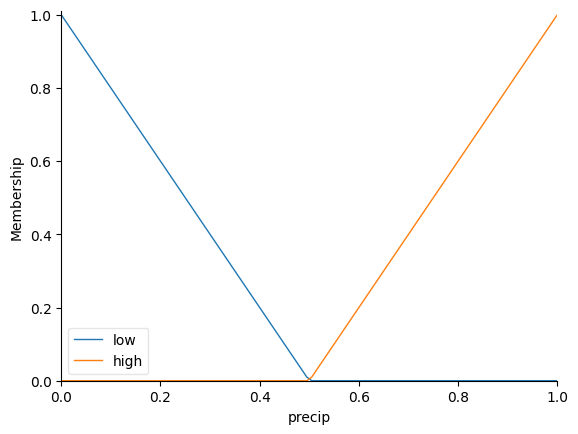

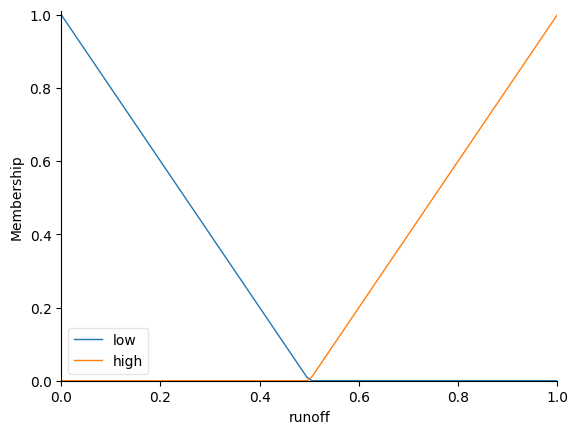

In [13]:
# e.g. for “precip” and “runoff”
precip.view()    # skfuzzy control built-in plotting
runoff.view()
plt.show()

 98%|===================| 15813/16060 [00:38<00:00]        

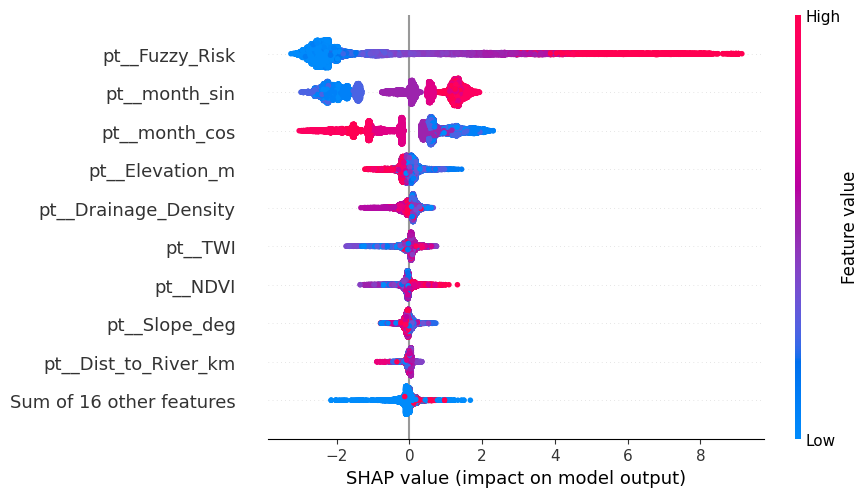

In [ ]:
# # 10. SHAP analysis on hybrid LGBM
# # extract underlying LGBM model & preprocessor
# lgbm_model = cal_pipe.estimator.named_steps['clf']
# preproc    = cal_pipe.estimator.named_steps['preproc']

# X_val_trans = preproc.transform(X_val)
# explainer    = shap.Explainer(lgbm_model, X_val_trans, feature_names=preproc.get_feature_names_out(),
#                               feature_perturbation="interventional")
# shap_values  = explainer(X_val_trans, check_additivity=False)
# shap.plots.beeswarm(shap_values)


In [14]:
# # 11. Fetch & prepare a 3‑day forecast for all regions (with logging and timeout)
# import os
# import sys
# import requests
# import numpy as np
# import pandas as pd

# # Ensure the project root is on the Python path so `config` resolves
# sys.path.insert(0, os.path.abspath(os.path.join('..')))
# from config.regions_config import REGIONS

# def fetch_forecast(api_key, days=3):
#     """
#     Fetches the next `days`‑day forecast from OpenWeatherMap for each region,
#     aggregates 3‑hourly precipitation to daily totals, attaches static terrain
#     features, computes cyclical month features, and normalizes.
#     """
#     cutoff = pd.Timestamp.now(tz='UTC') + pd.Timedelta(days=days)

#     # Map from DataFrame column name to key in REGIONS
#     static_map = {
#         'Elevation_m'      : 'elevation_m',
#         'Slope_deg'        : 'slope_deg',
#         'Drainage_Density' : 'drainage_density',
#         'Dist_to_River_km' : 'dist_to_river_km',
#         'Soil_Type'        : 'soil_type',
#         'Land_Cover'       : 'land_cover',
#         'TWI'              : 'TWI',
#         'NDVI'             : 'NDVI'
#     }

#     all_forecasts = []

#     for i, (region, info) in enumerate(REGIONS.items(), start=1):
#         print(f"[{i}/{len(REGIONS)}] Fetching forecast for {region}...", end="", flush=True)
#         lat, lon = info['lat'], info['lon']
#         url = (
#             f"https://api.openweathermap.org/data/2.5/forecast"
#             f"?lat={lat}&lon={lon}"
#             f"&appid={api_key}&units=metric"
#         )

#         # Request with a timeout to avoid hanging
#         try:
#             resp = requests.get(url, timeout=10)
#             resp.raise_for_status()
#         except Exception as e:
#             print(f" FAILED: {e}")
#             continue
#         else:
#             print(" OK")

#         data = resp.json()
#         if 'list' not in data:
#             print("  → unexpected response format, skipping")
#             continue

#         # Build a DataFrame of 3-hourly slices
#         df3h = pd.DataFrame(data['list'])
#         df3h['Date'] = pd.to_datetime(df3h['dt'], unit='s', utc=True)
#         df3h = df3h[df3h['Date'] < cutoff]

#         # Extract precipitation in the last 3h (or zero if missing)
#         if 'rain' in df3h.columns:
#             df3h['rain'] = df3h['rain'].apply(
#                 lambda v: v.get('3h', 0) if isinstance(v, dict) else 0
#             )
#         else:
#             df3h = df3h.assign(rain=0)

#         # Aggregate to daily precipitation
#         daily = (
#             df3h
#             .set_index('Date')
#             .resample('D')['rain']
#             .sum()
#             .rename('Precipitation')
#             .reset_index()
#         )
#         daily['Region'] = region

#         # Attach static terrain features
#         for dfcol, infokey in static_map.items():
#             daily[dfcol] = info[infokey]

#         # Cyclical month features
#         m = daily['Date'].dt.month
#         daily['month_sin'] = np.sin(2 * np.pi * m / 12)
#         daily['month_cos'] = np.cos(2 * np.pi * m / 12)

#         # Normalize precipitation (guard against all-zero)
#         maxp = daily['Precipitation'].max()
#         daily['Precipitation_norm'] = daily['Precipitation'] / (maxp if maxp > 0 else 1)
#         # Placeholder: use precip norm for runoff norm
#         daily['River_Level_norm'] = daily['Precipitation_norm']

#         all_forecasts.append(daily)

#     # Concatenate all region forecasts
#     return pd.concat(all_forecasts, ignore_index=True)


# # 11a. Define the forecast‐to‐hybrid‐pipeline wrapper
# def run_forecast_pipeline(df_fc_raw):
#     """
#     Takes the raw forecast DataFrame from fetch_forecast(),
#     runs the fuzzy FIS + calibrated ML hybrid, and returns
#     a DataFrame with 'prob_hybrid' and 'alert'.
#     """
#     # 1) Compute fuzzy risk for each row
#     fuzzy_scores = []
#     for p, r in zip(df_fc_raw['Precipitation_norm'], df_fc_raw['River_Level_norm']):
#         sim.input['precip']  = p
#         sim.input['runoff']  = r
#         sim.compute()
#         fuzzy_scores.append(sim.output['risk'])
#     df_fc_raw['Fuzzy_Risk'] = fuzzy_scores

#     # 2) Drop non‑features and predict with your calibrated ML pipeline
#     X_fc = df_fc_raw.drop(columns=['Date','Region'])
#     # `cal_pipe` is your CalibratedClassifierCV pipeline
#     prob_hybrid = cal_pipe.predict_proba(X_fc)[:,1]

#     # 3) Apply your tuned threshold `best_thr` to get binary alerts
#     alerts = (prob_hybrid >= best_thr).astype(int)

#     # 4) Return aligned DataFrame
#     return pd.DataFrame({
#         'prob_hybrid': prob_hybrid,
#         'alert'      : alerts
#     }, index=df_fc_raw.index)


# # Usage example:
# API_KEY = os.getenv("OWM_API_KEY")
# forecast_df_raw = fetch_forecast(API_KEY, days=3)

# # Feed into your hybrid pipeline
# results = run_forecast_pipeline(forecast_df_raw)
# print(results)


In [15]:
# # 12. Export calibrated hybrid pipeline
# os.makedirs('../backend/models', exist_ok=True)
# joblib.dump(cal_pipe, '../backend/models/hybrid_calibrated_pipeline.pkl')
# print("✅ Saved → backend/models/hybrid_calibrated_pipeline.pkl")